In [2]:
import numpy
import scipy
import pandas
import sklearn
import torch

print(f"NumPy version: {numpy.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"PyTorch version: {torch.__version__}")


NumPy version: 1.22.4
SciPy version: 1.8.1
Pandas version: 1.4.3
scikit-learn version: 1.1.1
PyTorch version: 1.11.0


In [3]:

import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
#import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [4]:

def load_iris_dataset():
    # Load iris dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 4, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 4, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels
    dataset['test_label'] = test_labels

    return dataset

iris_dataset = load_iris_dataset()

In [5]:

print("Train data shape: {}".format(iris_dataset['train_input'].shape))
print("Train target shape: {}".format(iris_dataset['train_label'].shape))
print("Test data shape: {}".format(iris_dataset['test_input'].shape))
print("Test target shape: {}".format(iris_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([120, 4])
Train target shape: torch.Size([120])
Test data shape: torch.Size([30, 4])
Test target shape: torch.Size([30])


In [6]:

def print_example_data_point(dataset):
    # Get column names from the dataset
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['setosa', 'versicolor', 'virginica']
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    for i, column_name in enumerate(column_names):
        print(f"{column_name}: {example_data_point[i]}")

    # Print the target value and the actual string label
    print(f"Target (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

print_example_data_point(iris_dataset)

sepal_length: 5.900000095367432
sepal_width: 3.0
petal_length: 5.099999904632568
petal_width: 1.7999999523162842
Target (numerical): 2
Actual Label: virginica


checkpoint directory created: ./model
saving model version 0.0


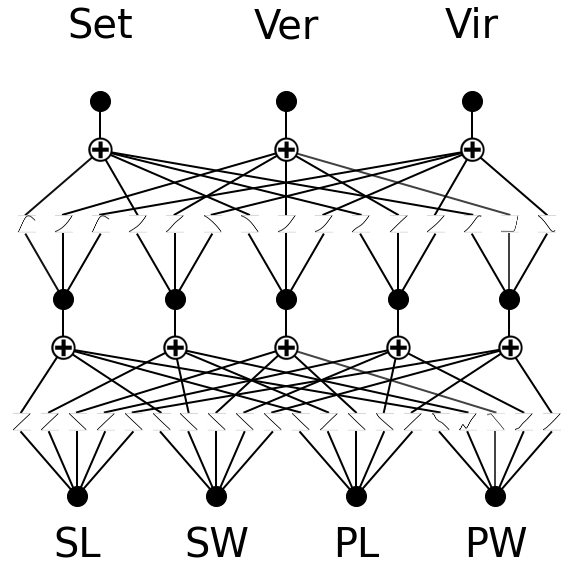

In [7]:

image_folder = 'video_img'

model = KAN(width=[4, 5, 3], grid=5, k=3, seed=0, device=device)

model(iris_dataset['train_input'])
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [9]:
def train_acc():
    return torch.mean((torch.argmax(model(iris_dataset['train_input']), dim=1) == iris_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(iris_dataset['test_input']), dim=1) == iris_dataset['test_label']).float())

results = model.fit(iris_dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=97, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)
     

| train_loss: 4.01e-01 | test_loss: 2.07e-01 | reg: 6.38e+01 | : 100%|█| 97/97 [07:00<00:00,  4.34s/

saving model version 0.1


In [10]:
results['train_acc'][-1], results['test_acc'][-1]


(0.9583333134651184, 1.0)

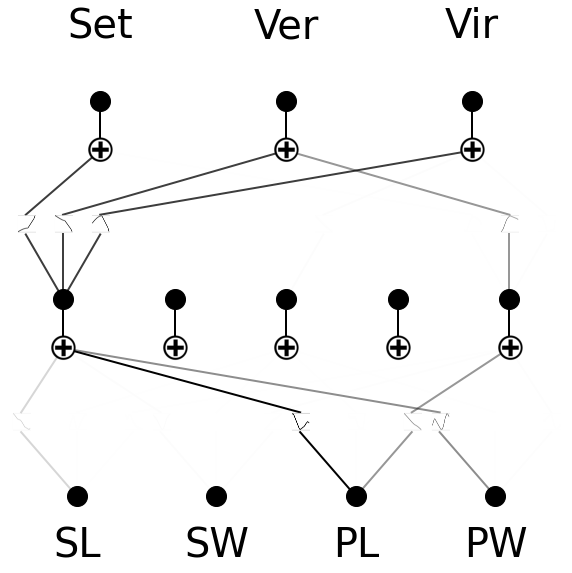

In [11]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])


In [12]:
video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

NameError: name 'moviepy' is not defined

saving model version 0.2


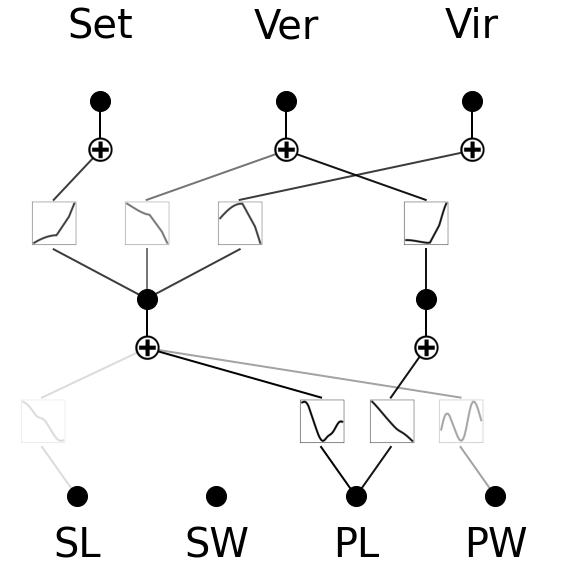

In [13]:
model = model.prune()
model(iris_dataset['train_input'])
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [14]:
# fine tune
results_1 = model.fit(iris_dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10.)
results_1['train_acc'][-1], results_1['test_acc'][-1]

| train_loss: 2.96e-01 | test_loss: 2.26e-01 | reg: 7.96e+01 | : 100%|█| 50/50 [00:00<00:00, 73.68it


saving model version 0.3


(0.9666666388511658, 1.0)

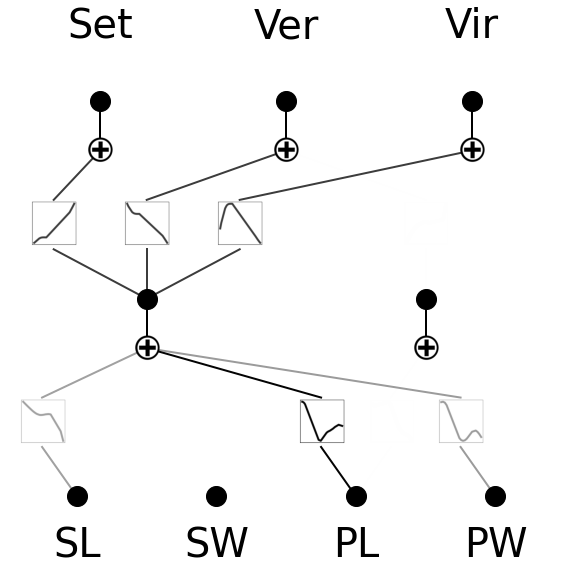

In [15]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])


In [16]:

lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.7822468280792236, c=1
fixing (0,0,1) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,2,0) with x, r2=0.6417362093925476, c=1
fixing (0,2,1) with x, r2=0.830729067325592, c=1
fixing (0,3,0) with x, r2=0.7085360884666443, c=1
fixing (0,3,1) with 0
fixing (1,0,0) with x, r2=0.983626663684845, c=1
fixing (1,0,1) with x, r2=0.9898881912231445, c=1
fixing (1,0,2) with x, r2=0.7220776081085205, c=1
fixing (1,1,0) with 0
fixing (1,1,1) with x, r2=0.7339197397232056, c=1
fixing (1,1,2) with 0
saving model version 0.4


In [17]:
formula1, formula2, formula3 = model.symbolic_formula()[0]


In [18]:
formula1


-56.1583451441451*x_1 - 142.788050146452*x_3 - 59.0134862758649*x_4 + 1215.41186533823

In [19]:

from sympy import *

simplify(formula1)
     

-56.1583451441451*x_1 - 142.788050146452*x_3 - 59.0134862758649*x_4 + 1215.41186533823

In [21]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 5)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(5, 3)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [22]:

def load_iris_dataset():
    # Load California housing dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=10, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=10, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_iris_dataset()

In [23]:

model = IrisNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 1.2487523555755615
Epoch 2, Loss: 1.1193439960479736
Epoch 3, Loss: 1.0969926118850708
Epoch 4, Loss: 1.1214568614959717
Epoch 5, Loss: 1.0410319566726685
Epoch 6, Loss: 0.9606224298477173
Epoch 7, Loss: 0.8779047727584839
Epoch 8, Loss: 0.7295383214950562
Epoch 9, Loss: 0.621228814125061
Epoch 10, Loss: 0.6330350637435913
Epoch 11, Loss: 0.48872771859169006
Epoch 12, Loss: 0.37480777502059937
Epoch 13, Loss: 0.39156994223594666
Epoch 14, Loss: 0.556174635887146
Epoch 15, Loss: 0.3924495279788971
Epoch 16, Loss: 0.36115410923957825
Epoch 17, Loss: 0.2940262258052826
Epoch 18, Loss: 0.2284572571516037
Epoch 19, Loss: 0.27161455154418945
Epoch 20, Loss: 0.29116353392601013
Epoch 21, Loss: 0.25526243448257446
Epoch 22, Loss: 0.17724177241325378
Epoch 23, Loss: 0.23907470703125
Epoch 24, Loss: 0.1902826577425003
Epoch 25, Loss: 0.2763308584690094
Epoch 26, Loss: 0.24401962757110596
Epoch 27, Loss: 0.14134946465492249
Epoch 28, Loss: 0.1962343156337738
Epoch 29, Loss: 0.20547

In [ ]:
test_model(model, test_loader)


Accuracy: 96.66666666666667%


: 